## Purpose

Let us explore time series analysis.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
from scipy.signal import periodogram

In [2]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data
data_dir ="store_series"
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
sales = pd.read_csv(
    data_dir +'/train.csv',
        dtype=dtype,
        parse_dates=['date'],
)


In [3]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
sales = sales[['date','sales']].groupby('date').mean().reset_index()
sales.head()

,date,sales
0,2013-01-01,1.409438
1,2013-01-02,278.390808
2,2013-01-03,202.840195
3,2013-01-04,198.911163
4,2013-01-05,267.873260


In [5]:
# we have lo ts of daues 1684, the first day seems off so we are going to delete it!
sales['lag'] = sales['sales'].shift(1)
sales['lag_on_week'] = sales['sales'].shift(7)
# let us just delete the first two rows 
sales = sales.iloc[8:].reset_index().drop('index', axis=1)

In [6]:
sales['time'] = sales.index + 1

In [7]:
sales.head(8)

,date,sales,lag,lag_on_week,time
0,2013-01-09,169.770370,178.646347,278.390808,1
1,2013-01-10,145.332214,169.770370,202.840195,2
2,2013-01-11,162.591293,145.332214,198.911163,3
3,2013-01-12,226.295303,162.591293,267.873260,4
4,2013-01-13,260.739929,226.295303,291.636017,5
5,2013-01-14,164.617493,260.739929,188.621109,6
6,2013-01-15,167.861710,164.617493,178.646347,7
7,2013-01-16,178.646408,167.861710,169.770370,8


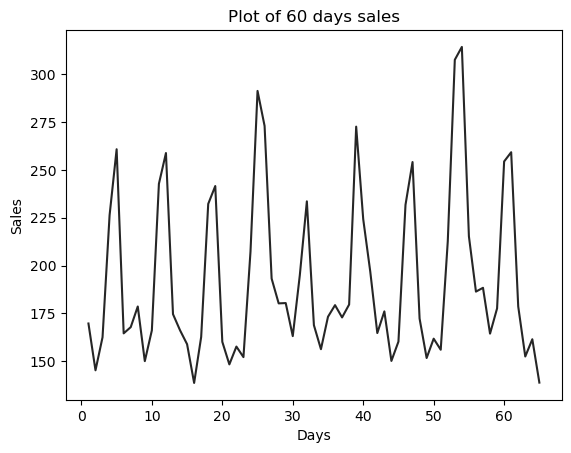

In [8]:
fig, ax = plt.subplots()
sub_sale = sales.iloc[:65]
ax.plot(sub_sale['time'], sub_sale['sales'], '-', color='0.15')
ax.set_ylabel('Sales')
ax.set_xlabel('Days')
ax.set_title('Plot of 60 days sales');

We can clearly see the structure of the data. It seems like we have weekly seasonalyty in our hands (we have peak nearly every 7 days). We are going to explore this data in more detail! And we are going to test whether we have indeeed a seasonalyty of 7 days.

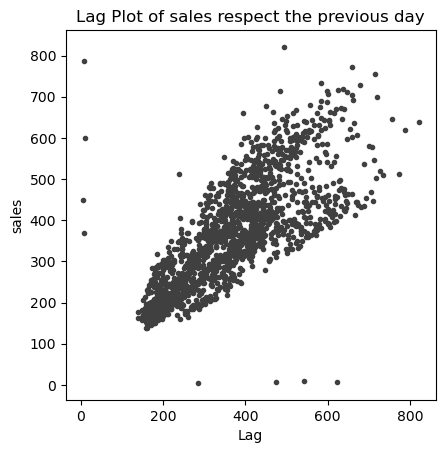

In [9]:
fig, ax = plt.subplots()
ax.plot(sales['lag'], sales['sales'], '.', color='0.25')
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag')
ax.set_title('Lag Plot of sales respect the previous day');

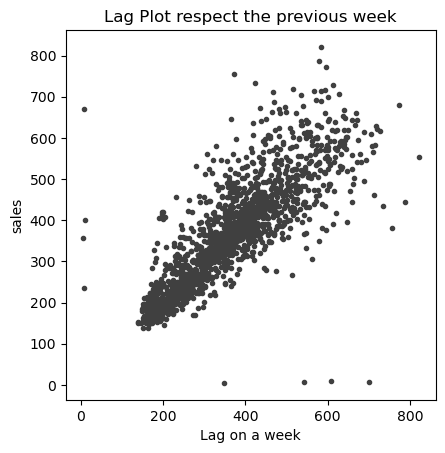

In [10]:
fig, ax = plt.subplots()
ax.plot(sales['lag_on_week'], sales['sales'], '.', color='0.25')
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag on a week')
ax.set_title('Lag Plot respect the previous week');

It looks stronger the relationship with respect the previous week (we see a clearer line).

### A Simple Regression Model


In [11]:
index_to_train = int(sales.shape[0]*(0.8))
X = sales[['lag','lag_on_week','time']]
y = sales['sales']
train_X = X[:index_to_train]
train_y = y[:index_to_train]

val_X = X[index_to_train: ]
val_y = y[index_to_train: ]
# You can check the division was correct like this
# train_X.tail()
# val_X.head()
reg = LinearRegression().fit(train_X, train_y)

In [12]:
# this is the variance in the data explain by the model
reg.score(X, y)

0.7573959885701435

In [13]:
reg.coef_

array([0.36162786, 0.5118855 , 0.02694144])

In [14]:
reg.intercept_

24.144924898163538

The second coefficient is the one that has the bigger impact in the prediction. It gets more than 50% of their sales (according to the model) of the previous month. 

### Notice
We could possibly improve the model creating hot encoding, one for tuesday, wednesday, .. sunday. All the coefficients would be compare to the baseline monday that we keep it out in the dummy variables. Remember that Linear regression uses the fact that the independant variables are not correlated between them.

Notice that the seasonality we just guess it, out of nothing! 

Can we actually find it out mathematically?
-(answer) Yes!, with a periodogram.


In [15]:
def take_max_frequency(freqencies,spectrum):
    # just initialitition
    max_spectrum = spectrum[0]
    max_frequency = freqencies[0]
    i = 1
    while i < len(spectrum):
        if max_spectrum < spectrum[i]:
            max_spectrum = spectrum[i]
            max_frequency = freqencies[i]
        i = i +1
    return max_frequency

def plot_periodogram(ts, detrend='linear', ax=None):
    # with detrend='linear' we are going to take away the trend to really see the frequency
    # A year is the lowest frequency
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    max_frequency = take_max_frequency(freqencies,spectrum)
    return print(f"max frequency found in: {max_frequency}"), ax

max frequency found in: 52.2673031026253


(None, <Axes: title={'center': 'Periodogram'}, ylabel='Variance'>)

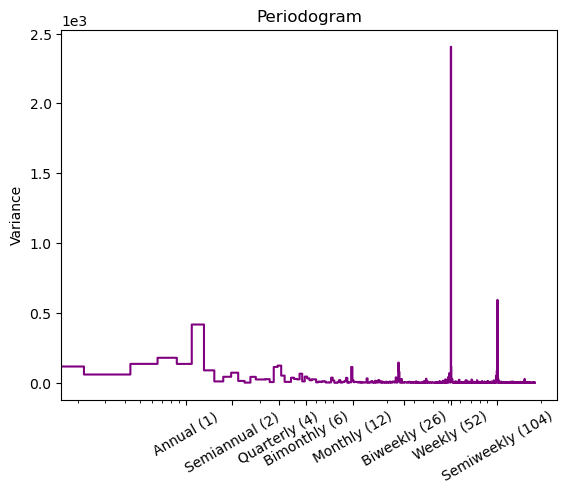

In [16]:
plot_periodogram(y)

In [17]:
str(f"""Remember that a year has {round(365/7,2)} weeks. So indeed the stronger Seasonality was the week!!""")

'Remember that a year has 52.14 weeks. So indeed the stronger Seasonality was the week!!'

##### notice we could use the frequency 1,2,12,52 to see if there are more Seasonality  in a year, semester, month and of course week. We would left that for the earger reader :) 